Alles beginnt mit dem Import von Bibliotheken und Plug-Ins.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium

Das Programm liest die Datasette

In [2]:
data = pd.read_csv("GlobalLandTemperaturesByCity.csv")
data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


Hier geben wir ein Histogramm nach Datum aus.

<AxesSubplot:>

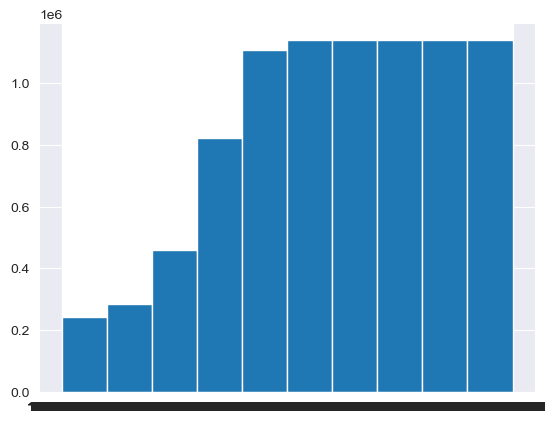

In [3]:
data['dt'].hist()

Die Grundidee wäre, eine monatliche Durchschnittstemperatur für jede Stadt im Datensatz zu haben, da die monatliche Durchschnittstemperatur konstant bleiben muss. Es genügt, die Zeilen mit Temperaturen mit Daten zu speichern, die seit 1980 beginnen.

In [4]:
data.dt = pd.to_datetime(data.dt)

newer_climate_data = data[pd.DatetimeIndex(data['dt']).year >= 1980].copy()
newer_climate_data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
2834,1980-01-01,-1.850,0.363,Århus,Denmark,57.05N,10.33E
2835,1980-02-01,-2.171,0.377,Århus,Denmark,57.05N,10.33E
2836,1980-03-01,0.625,0.178,Århus,Denmark,57.05N,10.33E
2837,1980-04-01,6.151,0.203,Århus,Denmark,57.05N,10.33E
2838,1980-05-01,11.434,0.226,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


Wir entfernen die Nullwerte und fügen drei Spalten hinzu: Jahr, Monat, Tag

In [5]:
newer_climate_data.dropna(inplace=True)

newer_climate_data['Year'] = pd.DatetimeIndex(newer_climate_data['dt']).year
newer_climate_data['Month'] = pd.DatetimeIndex(newer_climate_data['dt']).month
newer_climate_data['Day'] = pd.DatetimeIndex(newer_climate_data['dt']).day
newer_climate_data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,Day
2834,1980-01-01,-1.850,0.363,Århus,Denmark,57.05N,10.33E,1980,1,1
2835,1980-02-01,-2.171,0.377,Århus,Denmark,57.05N,10.33E,1980,2,1
2836,1980-03-01,0.625,0.178,Århus,Denmark,57.05N,10.33E,1980,3,1
2837,1980-04-01,6.151,0.203,Århus,Denmark,57.05N,10.33E,1980,4,1
2838,1980-05-01,11.434,0.226,Århus,Denmark,57.05N,10.33E,1980,5,1
...,...,...,...,...,...,...,...,...,...,...
8599206,2013-04-01,7.710,0.182,Zwolle,Netherlands,52.24N,5.26E,2013,4,1
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E,2013,5,1
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E,2013,6,1
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E,2013,7,1


Nun, einige der Probleme dieses Datensatzes bezüglich dessen, was ich tun werde, sind:

    Pro Stadt wird pro Monat und Jahr eine Messung durchgeführt;
    Es gibt Städte mit dem gleichen Namen, aber verschiedene Länder;
    Es gibt mehrere Städte mit den gleichen Daten, aber nur der Name der Stadt unterscheidet sich (z. B. «Baia Mare» und «Oradea»).

Der erste Punkt ist in diesem Fall nicht so wichtig, kann aber andere beeinflussen. Die Lösung für den zweiten Punkt besteht darin, immer die Stadt-Land-Spalten beizubehalten, nicht nur den Namen der Stadt. Und was den letzten Punkt betrifft, besteht die Lösung darin, Zeilen mit Duplikaten in diesem Sinne zu entfernen (denn am Ende möchte ich nur eine einfache Punktkarte).

In [6]:
print("Notice that the day is always 1")
print(newer_climate_data[(newer_climate_data['City'] == 'London') & (newer_climate_data['Month'] == 1)].Day.unique())

print("\nMultiple countries with the same city name")
print(newer_climate_data[(newer_climate_data['City'] == 'Worcester')].Country.unique())

print("\nNotice that the data is the same in the output")
print(newer_climate_data[(newer_climate_data['City'] == 'Baia Mare') & (newer_climate_data['Year'] == 2000)].head())
print("\nAnd now Oradea")
print(newer_climate_data[(newer_climate_data['City'] == 'Oradea') & (newer_climate_data['Year'] == 2000)].head())

Notice that the day is always 1
[1]

Multiple countries with the same city name
['South Africa' 'United Kingdom' 'United States']

Notice that the data is the same in the output
               dt  AverageTemperature  AverageTemperatureUncertainty  \
566045 2000-01-01              -4.727                          0.383   
566046 2000-02-01               1.020                          0.495   
566047 2000-03-01               4.402                          0.207   
566048 2000-04-01              13.299                          0.199   
566049 2000-05-01              17.261                          0.317   

             City  Country Latitude Longitude  Year  Month  Day  
566045  Baia Mare  Romania   47.42N    22.50E  2000      1    1  
566046  Baia Mare  Romania   47.42N    22.50E  2000      2    1  
566047  Baia Mare  Romania   47.42N    22.50E  2000      3    1  
566048  Baia Mare  Romania   47.42N    22.50E  2000      4    1  
566049  Baia Mare  Romania   47.42N    22.50E  2000      5 

Jetzt ist es an der Zeit, den Durchschnitt für jeden Monat nach Städten zu berechnen

In [30]:
keep_columns = ['City', 'Country', 'Month', 'AverageTemperature']
mean_data = newer_climate_data[keep_columns].groupby(['City', 'Country', 'Month']).mean().reset_index()
mean_data.groupby(['City', 'Country']).head()

,City,Country,Month,AverageTemperature
0,A Coruña,Spain,1,9.069588
1,A Coruña,Spain,2,9.612059
2,A Coruña,Spain,3,11.434324
3,A Coruña,Spain,4,12.170882
4,A Coruña,Spain,5,14.490706
...,...,...,...,...
41868,Ürümqi,China,1,-14.634382
41869,Ürümqi,China,2,-10.886088
41870,Ürümqi,China,3,-0.933000
41871,Ürümqi,China,4,10.586441


Schauen wir uns nun die Beziehung zwischen Durchschnittstemperatur- und Unsicherheitsbewertungsdaten an

array([[<AxesSubplot:xlabel='AverageTemperature', ylabel='AverageTemperature'>,
        <AxesSubplot:xlabel='AverageTemperatureUncertainty', ylabel='AverageTemperature'>],
       [<AxesSubplot:xlabel='AverageTemperature', ylabel='AverageTemperatureUncertainty'>,
        <AxesSubplot:xlabel='AverageTemperatureUncertainty', ylabel='AverageTemperatureUncertainty'>]],
      dtype=object)

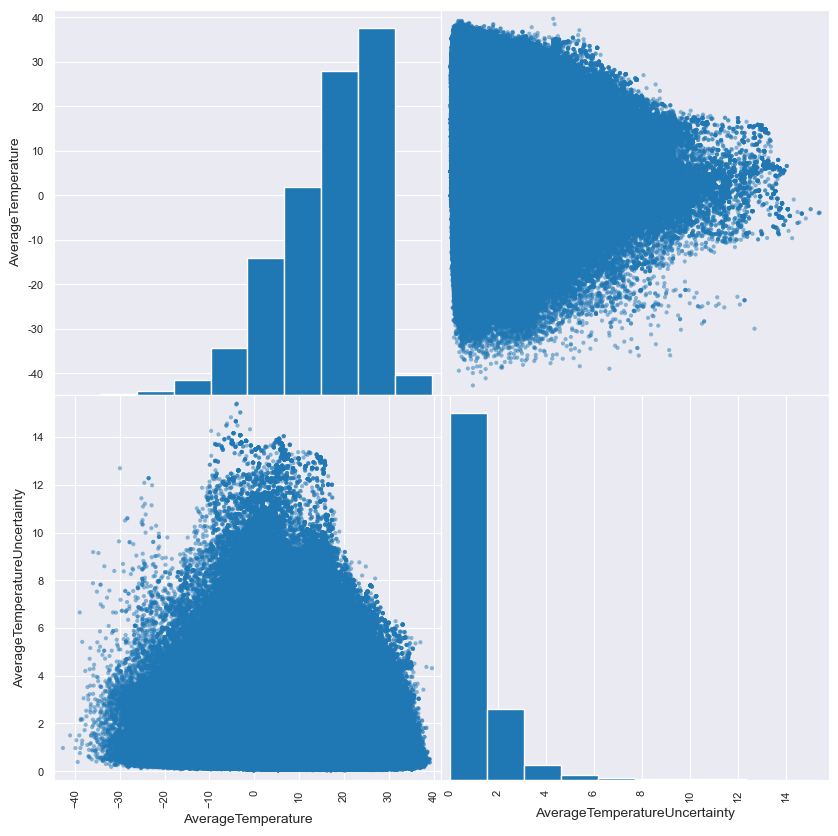

In [31]:
from pandas.plotting import scatter_matrix
col1=['AverageTemperature','AverageTemperatureUncertainty']
data[col1].fillna(0, inplace=True)
scatter_matrix(data[col1], alpha=0.5, figsize=(10,10))

Schauen wir uns den Korrelationskoeffizienten dieser Spalte an.

In [9]:
data[col1].corr()

,AverageTemperature,AverageTemperatureUncertainty
AverageTemperature,1.000000,-0.228159
AverageTemperatureUncertainty,-0.228159,1.000000


Ich werde einen separaten Datenrahmen erstellen, der nur den Namen der Städte, den Standort und die Temperatur für jeden Monat enthält

In [10]:
cities_data = newer_climate_data[['City', 'Country', 'Latitude', 'Longitude']].copy()
cities_data.drop_duplicates(inplace=True)
cities_data.reset_index(drop=True, inplace=True)

# Hinzufügen von Monatsspalten
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for month in months:
    cities_data[month] = np.nan

# Die Idee ist, jede Stadt im Datenrahmen Spalte für Spalte zu füllen
for idx in cities_data.index:

    city_part = mean_data[(mean_data['City'] == cities_data.loc[idx, 'City']) & 
                          (mean_data['Country'] == cities_data.loc[idx, 'Country'])]

    # Hinzufügen von monatlicher Temperatur
    for m_index, month in enumerate(months):
        cities_data.loc[idx, month] = city_part[city_part['Month'] == m_index + 1].AverageTemperature.mean()

cities_data.head()

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Århus,Denmark,57.05N,10.33E,0.827235,0.882647,2.956647,6.876235,11.952441,15.120265,17.443147,17.004941,13.450667,8.994242,4.875606,1.720667
1,Çorlu,Turkey,40.99N,27.69E,4.781765,5.025000,7.516118,11.844059,16.742029,21.168912,23.570618,23.703088,20.005333,15.339455,10.453121,6.756333
2,Çorum,Turkey,40.99N,34.08E,-0.015941,1.258529,4.988441,9.824706,14.268882,18.162853,21.086824,21.111088,17.123030,11.684424,5.553576,1.588879
3,Öskemen,Kazakhstan,50.63N,82.39E,-15.310353,-13.983118,-7.189235,4.152941,12.286912,17.172382,18.925265,17.049206,11.132152,3.744758,-5.860485,-12.759848
4,Ürümqi,China,44.20N,87.20E,-14.634382,-10.886088,-0.933000,10.586441,17.582706,22.255088,24.089471,22.765618,16.895515,7.981909,-1.710818,-10.914606


Geographische Beobachtungen und Verarbeitung

Das geographische Problem der Regionen der südlichen Hemisphäre besteht darin, dass ihr Winter zwischen Mai und August stattfindet.

Um also zu vermeiden, dass verschiedene klimatische Regionen mit den gleichen monatlichen Temperaturen, aber unterschiedlichen Jahreszeiten existieren, müssen wir die Temperaturen innerhalb von sechs Monaten "drehen" (im Wesentlichen die Werte nach rechts verschieben).

In [11]:
# Vergessen wir nicht, doppelte Zeilen zu entfernen (Problem 3 oben)
cities_data_normalized = cities_data.drop_duplicates(subset=['Jan', 'Feb', 'Mar', 'Apr', 'May']).copy()

# Sie können sehen, dass die Temperaturen im Juni-August niedriger sind als im Dezember-Februar
cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
33,Adelaide,Australia,34.56S,138.16E,22.438059,22.614853,20.428765,17.192324,14.234735,11.552382,10.712088,11.580647,13.541000,15.647970,18.922727,20.609212
36,Adiwerna,Indonesia,7.23S,109.46E,26.277176,26.328176,26.644765,26.877853,27.193676,26.649500,26.094176,26.143088,26.724636,27.168242,27.107485,26.571758
63,Alagoinhas,Brazil,12.05S,37.81W,27.044441,27.273618,27.402176,26.705500,25.882412,24.845941,24.183118,24.284706,25.099485,25.940606,26.623576,26.821636
68,Alberton,South Africa,26.52S,28.66E,20.131912,19.993412,18.666235,15.464941,12.150000,9.045824,9.006647,12.014059,15.847545,17.589879,18.738848,19.557758
70,Albury,Australia,36.17S,147.18E,21.792265,21.580588,18.504059,14.106676,10.609382,7.741147,6.824500,8.120000,10.534485,13.232667,16.890364,19.233788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,Uruguaiana,Brazil,29.74S,57.23W,26.788147,25.701382,24.309000,20.622559,17.119676,14.517353,14.020529,16.051235,17.481303,20.494333,23.154152,25.498909
3296,Vitória Da Conquista,Brazil,15.27S,40.83W,23.949265,24.206147,23.906971,22.822176,21.505147,19.958941,19.354441,19.942324,21.395364,22.620303,23.219970,23.585848
3350,Windhoek,Namibia,23.31S,16.60E,23.785412,23.397588,22.815647,20.558765,17.783088,14.910735,14.817941,16.695353,19.631545,21.770061,23.291818,24.063727
3360,Worcester,South Africa,32.95S,20.11E,22.754029,22.855471,20.992088,17.149353,13.624147,10.535324,10.037824,11.066735,13.527091,16.407879,19.127182,21.401879


In [12]:
# Wir bekommen Städte in der südlichen Hemisphäre
southern = cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

# Rotation um 6 Monate
for index in southern.index:
    for idx, month in enumerate(months):
        cities_data_normalized.loc[index, month] = cities_data.loc[index, months[(idx + 6) % 12]]

# Jetzt sieht es normal aus (der Sommer ist heißer als der Winter)
cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
33,Adelaide,Australia,34.56S,138.16E,10.712088,11.580647,13.541000,15.647970,18.922727,20.609212,22.438059,22.614853,20.428765,17.192324,14.234735,11.552382
36,Adiwerna,Indonesia,7.23S,109.46E,26.094176,26.143088,26.724636,27.168242,27.107485,26.571758,26.277176,26.328176,26.644765,26.877853,27.193676,26.649500
63,Alagoinhas,Brazil,12.05S,37.81W,24.183118,24.284706,25.099485,25.940606,26.623576,26.821636,27.044441,27.273618,27.402176,26.705500,25.882412,24.845941
68,Alberton,South Africa,26.52S,28.66E,9.006647,12.014059,15.847545,17.589879,18.738848,19.557758,20.131912,19.993412,18.666235,15.464941,12.150000,9.045824
70,Albury,Australia,36.17S,147.18E,6.824500,8.120000,10.534485,13.232667,16.890364,19.233788,21.792265,21.580588,18.504059,14.106676,10.609382,7.741147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,Uruguaiana,Brazil,29.74S,57.23W,14.020529,16.051235,17.481303,20.494333,23.154152,25.498909,26.788147,25.701382,24.309000,20.622559,17.119676,14.517353
3296,Vitória Da Conquista,Brazil,15.27S,40.83W,19.354441,19.942324,21.395364,22.620303,23.219970,23.585848,23.949265,24.206147,23.906971,22.822176,21.505147,19.958941
3350,Windhoek,Namibia,23.31S,16.60E,14.817941,16.695353,19.631545,21.770061,23.291818,24.063727,23.785412,23.397588,22.815647,20.558765,17.783088,14.910735
3360,Worcester,South Africa,32.95S,20.11E,10.037824,11.066735,13.527091,16.407879,19.127182,21.401879,22.754029,22.855471,20.992088,17.149353,13.624147,10.535324


Ich werde KMeans verwenden, um die Klimaregionen zu clustern
Berechnen Verzerrung für einen Bereich von Anzahl der Cluster

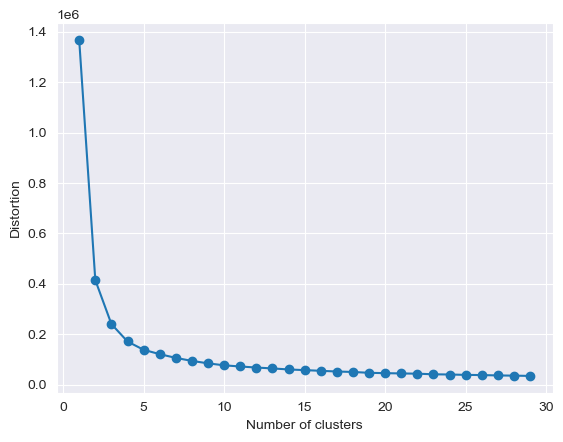

In [13]:
distortions = []
dropped_columns = ['City', 'Country', 'Latitude', 'Longitude']
for i in range(1, 30):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cities_data_normalized.drop(dropped_columns, axis=1))
    distortions.append(km.inertia_)

# Plot the distortion on the graph
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Aber was ist nun die optimale Anzahl an Clustern beim k-Means Verfahren?
Hierfür gibt es mit der Ellenbogen-Methode einen gängigen Weg, um die geeignete Anzahl der Cluster zu bestimmen.

In [14]:
km = KMeans(
    n_clusters=27, init='random',
    n_init=20, max_iter=500,
    tol=1e-04, random_state=0,
    algorithm='elkan'
)
# Hinzufügen eines Cluster-index zu einer Tabelle
pred = km.fit_predict(cities_data_normalized.drop(dropped_columns, axis=1))
cities_data_normalized['pred'] = pred
cities_data_normalized

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,pred
0,Århus,Denmark,57.05N,10.33E,0.827235,0.882647,2.956647,6.876235,11.952441,15.120265,17.443147,17.004941,13.450667,8.994242,4.875606,1.720667,11
1,Çorlu,Turkey,40.99N,27.69E,4.781765,5.025000,7.516118,11.844059,16.742029,21.168912,23.570618,23.703088,20.005333,15.339455,10.453121,6.756333,16
2,Çorum,Turkey,40.99N,34.08E,-0.015941,1.258529,4.988441,9.824706,14.268882,18.162853,21.086824,21.111088,17.123030,11.684424,5.553576,1.588879,13
3,Öskemen,Kazakhstan,50.63N,82.39E,-15.310353,-13.983118,-7.189235,4.152941,12.286912,17.172382,18.925265,17.049206,11.132152,3.744758,-5.860485,-12.759848,7
4,Ürümqi,China,44.20N,87.20E,-14.634382,-10.886088,-0.933000,10.586441,17.582706,22.255088,24.089471,22.765618,16.895515,7.981909,-1.710818,-10.914606,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,Zhytomyr,Ukraine,50.63N,29.15E,-4.006882,-3.551676,1.074382,8.401382,14.652824,17.780765,19.724676,18.660294,13.489939,7.659152,1.828818,-2.602606,5
3500,Ziguinchor,Senegal,12.05N,16.44W,24.499824,25.282735,25.940529,26.088324,27.343912,28.244882,27.660353,27.242941,27.353758,27.910303,27.258242,25.157152,3
3501,Zinder,Niger,13.66N,9.08E,21.961735,25.303000,29.833676,33.330706,34.023412,32.327206,29.297529,27.967382,29.353606,30.044697,26.862697,22.843515,2
3504,Zonguldak,Turkey,40.99N,31.95E,1.728000,2.715118,5.904588,10.409176,14.942324,18.914147,21.593147,21.557000,17.655606,12.759303,7.300909,3.529636,13


Erstellen einer Regionalkarte
Städte sind jetzt für jede klimatische Region in einer anderen Farbe auf die Weltkarte aufgetragen.

In [15]:
world_map= folium.Map()
geolocator = Nominatim(user_agent="Temperatures")

# Jedem Cluster seine eigene Farbe geben
city_color = [
    "red",
    "orange",
    "indigo",
    "green",
    "blue",
    "yellow",
    "violet",
    "purple",
    "pink",
    "silver",
    "gold",
    "lightgreen",
    "brown",
    "black",
    "gray",
    "turquoise",
    "darkgrey",
    "lavender",
    "darkKhaki",
    "cdetBlue",
    "goldenRod",
    "darkSlateGray",
    "darkSlateBlue",
    "lightCoral",
    "navy",
    "paleGreen",
    "sienna"

]

# Hinzufügen jeder Datenzeile zu einer Karte als Punkt
for i in range(len(cities_data_normalized)):
        lat = float(cities_data_normalized.iloc[i]['Latitude'][:-1])
        long = float(cities_data_normalized.iloc[i]['Longitude'][:-1])
        if cities_data_normalized.iloc[i]['Latitude'][-1] == 'S':
            lat *= (-1)
        if cities_data_normalized.iloc[i]['Longitude'][-1] == 'W':
            long *= (-1)
        radius = 55000
        folium.Circle(location = [lat, long],
                      popup=cities_data_normalized.iloc[i]['City'],
                      radius=radius,
                      color=city_color[cities_data_normalized.iloc[i]['pred']],
                      fill=True,
                      fill_color=city_color[cities_data_normalized.iloc[i]['pred']]
                     ).add_to(world_map)

world_map